In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
from astropy.table import Table

In [5]:
# Set up directories
os.environ['HOME'] = 'C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir + '/cigalestuff/cigale/out/'
fits_file = tabledir + 'results.fits'
csv_file = 'testoutput.csv'  # Output CSV file
fits_file_output = 'testoutput.fits'

# Solar mass in kg
solar_mass_kg = 1.98847e30

# DGR parameters in log space
log_DGR = -1.86
DGR_err = 0.22  # DGR uncertainty in dex

# Load the FITS file
with fits.open(fits_file) as hdul:
    data = hdul[1].data

# Convert dust masses to solar masses
bayes_dust_mass_solar = data['bayes.dust.mass'] / solar_mass_kg
best_dust_mass_solar = data['best.dust.mass'] / solar_mass_kg

# Convert uncertainties to solar masses in log space
bayes_dust_mass_err_solar = data['bayes.dust.mass_err'] / (data['bayes.dust.mass'] * np.log(10))  # Convert to log space

# Extract relevant columns
id_col = data['id']
log_bayes_dust_mass = np.log10(bayes_dust_mass_solar)
log_best_dust_mass = np.log10(best_dust_mass_solar)

# Calculate log gas masses and their uncertainties
log_bayes_gas_mass = log_bayes_dust_mass - log_DGR
log_bayes_gas_mass_err = np.sqrt(bayes_dust_mass_err_solar**2 + DGR_err**2)

log_best_gas_mass = log_best_dust_mass - log_DGR
log_best_gas_mass_err = DGR_err  # Best dust mass assumed to have no additional error

# Create a DataFrame to store results
df = pd.DataFrame({
    'id': id_col,
    'log(bayes.dust.mass)': log_bayes_dust_mass,
    'log(bayes.dust.mass.err)': bayes_dust_mass_err_solar,
    'log(best.dust.mass)': log_best_dust_mass,
    'log(bayes.gas.mass)': log_bayes_gas_mass,
    'log(bayes.gas.mass.err)': log_bayes_gas_mass_err,
    'log(best.gas.mass)': log_best_gas_mass,
    'log(best.gas.mass.err)': log_best_gas_mass_err,
    'bayes.sfh.sfr' : data['bayes.sfh.sfr'],
})

# Export to CSV
df.to_csv(csv_file, index=False)
print(f"Data successfully written to {csv_file}")


Data successfully written to testoutput.csv


In [2]:
# Load the CSV file
csv_file = 'test.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_file)

# Function to calculate MH2 and its errors while handling NaN values
def calculate_mh2(row):
    if pd.isna(row['MHI']) or pd.isna(row['MH2_to_MHI']):
        return np.nan, np.nan, np.nan
    else:
        MH2 = row['MHI'] * row['MH2_to_MHI']
        
        # Calculate upper and lower errors in log space for MH2
        error_term_up = np.sqrt((row['MHI_err_up'] / row['MHI'])**2 + (row['MH2_to_MHI_err_up'] / row['MH2_to_MHI'])**2)
        error_term_down = np.sqrt((row['MHI_err_down'] / row['MHI'])**2 + (row['MH2_to_MHI_err_down'] / row['MH2_to_MHI'])**2)
        
        MH2_err_up = np.log10(MH2 * (1 + error_term_up))
        MH2_err_down = np.log10(MH2 * (1 + error_term_down))  # Ensure positive term in log

        return MH2, MH2_err_up, MH2_err_down

# Apply the function to calculate the new MH2 columns
df[['MH2', 'MH2_err_up', 'MH2_err_down']] = df.apply(lambda row: pd.Series(calculate_mh2(row)), axis=1)

# Convert all mass columns and errors to log10
mass_columns = ['MHI', 'MHI_err_up', 'MHI_err_down', 'MH2', 'MH2_err_up', 'MH2_err_down']
for col in mass_columns:
    df[col] = df[col].apply(lambda x: np.log10(x) if pd.notna(x) and x > 0 else np.nan)

df['Mgas'] = df.apply(
    lambda row: np.log10(10**row['MHI'] + 10**row['MH2']) 
    if pd.notna(row['MHI']) and pd.notna(row['MH2']) else np.nan,
    axis=1
)

# Save the modified DataFrame to a new CSV
output_csv = 'reference_gas_mass.csv'
df.to_csv(output_csv, index=False)

print(f"CSV file with MH2 and Mgas columns in log10 successfully written to {output_csv}")

CSV file with MH2 and Mgas columns in log10 successfully written to reference_gas_mass.csv


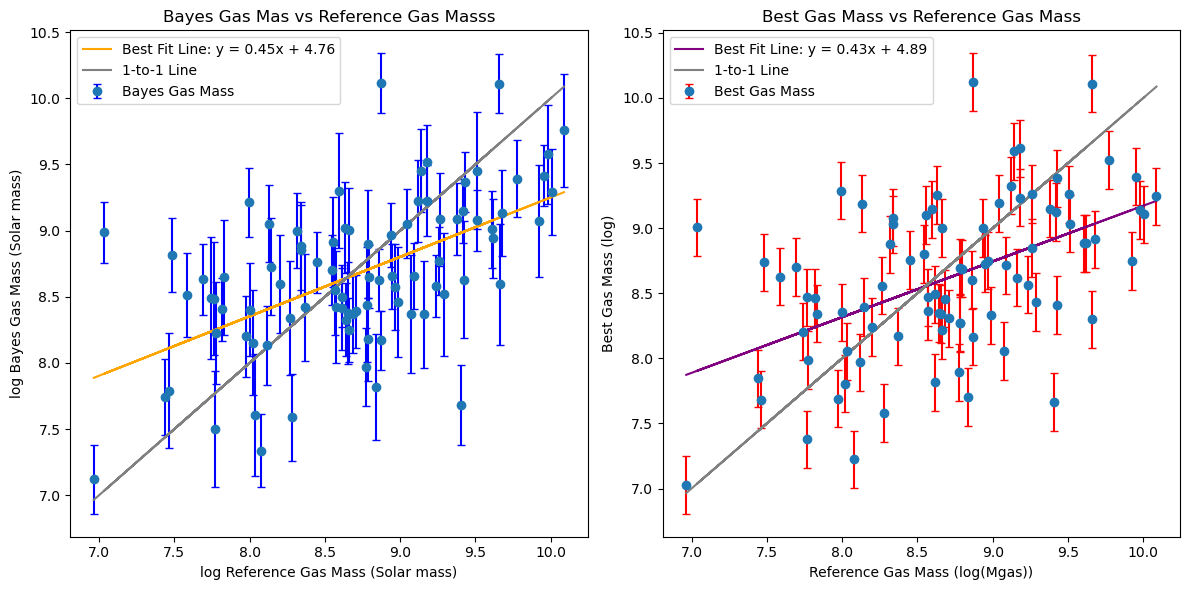

In [31]:
# Load CSV files
first_csv_file = 'reference_gas_mass.csv'  # Replace with the actual path
df1 = pd.read_csv(first_csv_file)
second_csv_file = 'testoutput.csv'  # Replace with the actual path
df2 = pd.read_csv(second_csv_file)

# Merge the DataFrames on VFID and id
merged_df = pd.merge(df1, df2, left_on='VFID', right_on='id')

# Extract necessary columns for plotting
Mgas = merged_df['MH2']
Mgas_err_up = merged_df['MH2_err_up']
Mgas_err_down = merged_df['MH2_err_down']

# Bayes gas mass columns
bayes_gas_mass = merged_df['log(bayes.gas.mass)']
bayes_gas_mass_err = merged_df['log(bayes.gas.mass.err)']

# Best gas mass columns
best_gas_mass = merged_df['log(best.gas.mass)']
best_gas_mass_err = merged_df['log(best.gas.mass.err)']

# Error calculation (assuming symmetrical errors for simplicity in plotting)
Mgas_err = np.maximum(Mgas_err_up, Mgas_err_down)

# Filter out non-zero and non-NaN values for best fit calculations
valid_bayes_mask = (Mgas > 0) & (bayes_gas_mass > 0) & (~np.isnan(Mgas)) & (~np.isnan(bayes_gas_mass))
valid_best_mask = (Mgas > 0) & (best_gas_mass > 0) & (~np.isnan(Mgas)) & (~np.isnan(best_gas_mass))

# Best fit lines
slope_bayes, intercept_bayes, _, _, _ = linregress(Mgas[valid_bayes_mask], bayes_gas_mass[valid_bayes_mask])
slope_best, intercept_best, _, _, _ = linregress(Mgas[valid_best_mask], best_gas_mass[valid_best_mask])

# Plotting
plt.figure(figsize=(12, 6))

# Plot 1: Mgas vs bayes_gas_mass
plt.subplot(1, 2, 1)
plt.errorbar(Mgas, bayes_gas_mass, yerr=bayes_gas_mass_err, fmt='o', ecolor='blue', capsize=3, label='Bayes Gas Mass')
plt.plot(Mgas, slope_bayes * Mgas + intercept_bayes, color='orange', linestyle='-', label=f'Best Fit Line: y = {slope_bayes:.2f}x + {intercept_bayes:.2f}')
plt.plot(Mgas, Mgas, color='gray', linestyle='-', label='1-to-1 Line')

plt.xlabel('log Reference Gas Mass (Solar mass)')
plt.ylabel('log Bayes Gas Mass (Solar mass)')
plt.title('Bayes Gas Mas vs Reference Gas Masss')
plt.legend()

# Plot 2: Mgas vs best_gas_mass
plt.subplot(1, 2, 2)
plt.errorbar(Mgas, best_gas_mass, yerr=best_gas_mass_err, fmt='o', ecolor='red', capsize=3, label='Best Gas Mass')
plt.plot(Mgas, slope_best * Mgas + intercept_best, color='purple', linestyle='-', label=f'Best Fit Line: y = {slope_best:.2f}x + {intercept_best:.2f}')
plt.plot(Mgas, Mgas, color='gray', linestyle='-', label='1-to-1 Line')

plt.xlabel('Reference Gas Mass (log(Mgas))')
plt.ylabel('Best Gas Mass (log)')
plt.title('Best Gas Mass vs Reference Gas Mass')
plt.legend()

# Adjust layout, save, and display
plt.tight_layout()
plt.savefig('gas_mass_plot_error.png', dpi=300, bbox_inches='tight')
plt.show()

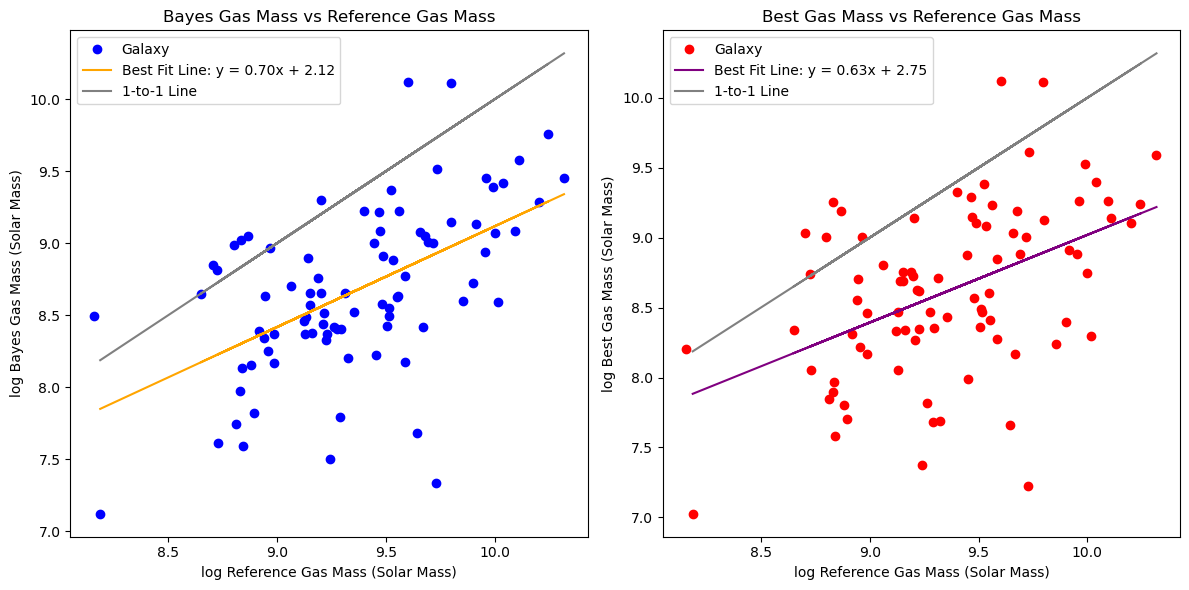

In [4]:
# Load CSV files
first_csv_file = 'reference_gas_mass.csv'  # Replace with the actual path
df1 = pd.read_csv(first_csv_file)
second_csv_file = 'testoutput.csv'  # Replace with the actual path
df2 = pd.read_csv(second_csv_file)

# Merge the DataFrames on VFID and id
merged_df = pd.merge(df1, df2, left_on='VFID', right_on='id')

# Extract necessary columns for plotting
Mgas = merged_df['Mgas']

# Bayes gas mass columns
bayes_gas_mass = merged_df['log(bayes.gas.mass)']

# Best gas mass columns
best_gas_mass = merged_df['log(best.gas.mass)']

# Filter out non-zero and non-NaN values for best fit calculations
valid_bayes_mask = (Mgas > 0) & (bayes_gas_mass > 0) & (~np.isnan(Mgas)) & (~np.isnan(bayes_gas_mass))
valid_best_mask = (Mgas > 0) & (best_gas_mass > 0) & (~np.isnan(Mgas)) & (~np.isnan(best_gas_mass))

# Best fit lines
slope_bayes, intercept_bayes, _, _, _ = linregress(Mgas[valid_bayes_mask], bayes_gas_mass[valid_bayes_mask])
slope_best, intercept_best, _, _, _ = linregress(Mgas[valid_best_mask], best_gas_mass[valid_best_mask])

# Plotting
plt.figure(figsize=(12, 6))

# Plot 1: Mgas vs bayes_gas_mass
plt.subplot(1, 2, 1)
plt.plot(Mgas, bayes_gas_mass, 'o', color='blue', label='Galaxy')
plt.plot(Mgas, slope_bayes * Mgas + intercept_bayes, color='orange', linestyle='-', label=f'Best Fit Line: y = {slope_bayes:.2f}x + {intercept_bayes:.2f}')
plt.plot(Mgas, Mgas, color='gray', linestyle='-', label='1-to-1 Line')

plt.xlabel('log Reference Gas Mass (Solar Mass)')
plt.ylabel('log Bayes Gas Mass (Solar Mass)')
plt.title('Bayes Gas Mass vs Reference Gas Mass')
plt.legend()

# Plot 2: Mgas vs best_gas_mass
plt.subplot(1, 2, 2)
plt.plot(Mgas, best_gas_mass, 'o', color='red', label='Galaxy')
plt.plot(Mgas, slope_best * Mgas + intercept_best, color='purple', linestyle='-', label=f'Best Fit Line: y = {slope_best:.2f}x + {intercept_best:.2f}')
plt.plot(Mgas, Mgas, color='gray', linestyle='-', label='1-to-1 Line')

plt.xlabel('log Reference Gas Mass (Solar Mass)')
plt.ylabel('log Best Gas Mass (Solar Mass)')
plt.title('Best Gas Mass vs Reference Gas Mass')
plt.legend()

# Adjust layout, save, and display
plt.tight_layout()
plt.savefig('gas_mass_plot_no_error2.png', dpi=300, bbox_inches='tight')
plt.show()

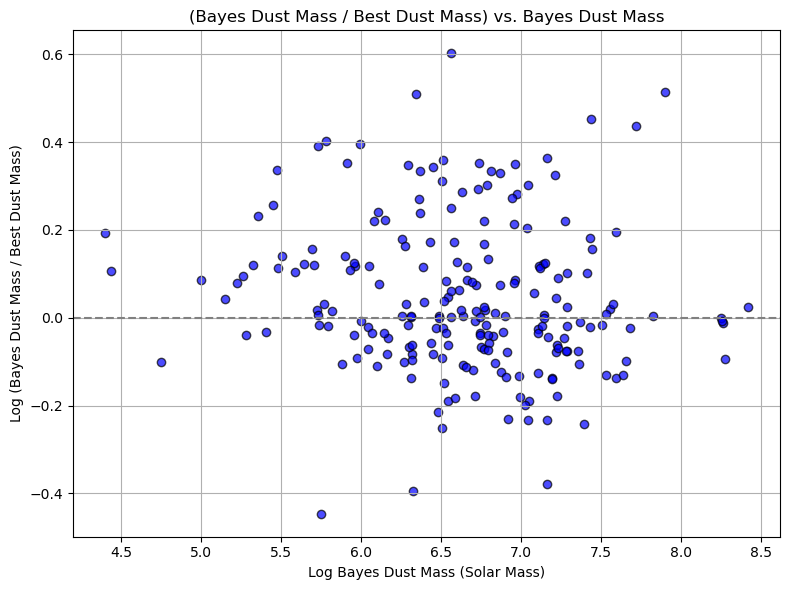

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Set up directories
os.environ['HOME'] = 'C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir + '/cigalestuff/cigale/out/'
fits_file = tabledir + 'results.fits'

# Solar mass in kg
solar_mass_kg = 1.98847e30

# Load the FITS file
with fits.open(fits_file) as hdul:
    data = hdul[1].data

# Convert dust masses to solar masses
bayes_dust_mass_solar = data['bayes.dust.mass'] / solar_mass_kg
best_dust_mass_solar = data['best.dust.mass'] / solar_mass_kg

# Convert to log space
log_bayes_dust_mass = np.log10(bayes_dust_mass_solar)
log_best_dust_mass = np.log10(best_dust_mass_solar)

# Calculate log(Dust Mass Bayes / Dust Mass Best)
log_mass_ratio = log_bayes_dust_mass - log_best_dust_mass

# Plotting log(Dust Mass Bayes / Dust Mass Best) vs. log(Dust Mass Bayes)
plt.figure(figsize=(8, 6))
plt.scatter(log_bayes_dust_mass, log_mass_ratio, color='blue', alpha=0.7, edgecolor='black')
plt.axhline(0, color='gray', linestyle='--')  # Add a horizontal line as the 1-to-1 line
plt.xlabel('Log Bayes Dust Mass (Solar Mass)')
plt.ylabel('Log (Bayes Dust Mass / Best Dust Mass)')
plt.title('(Bayes Dust Mass / Best Dust Mass) vs. Bayes Dust Mass')
plt.grid(True)

# Show and save the plot
plt.tight_layout()
plt.savefig('dust_mass_ratio_vs_bayes_mass.png', dpi=300)
plt.show()


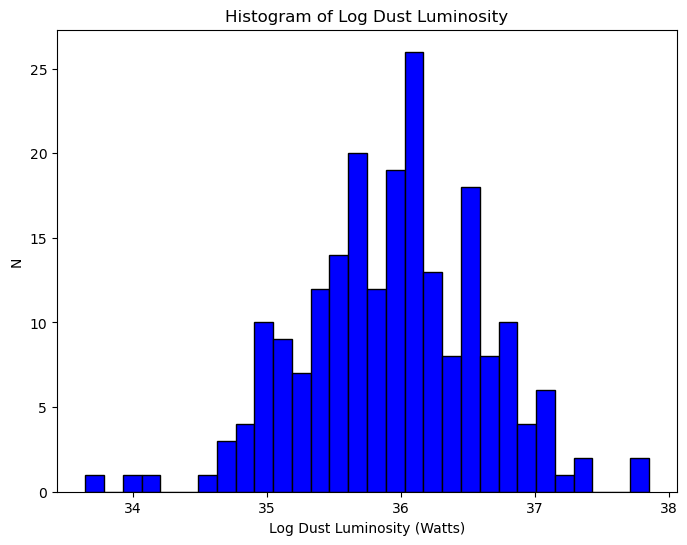

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Set up directories
os.environ['HOME'] = 'C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir + '/cigalestuff/cigale/out/'
fits_file = tabledir + 'results.fits'

# Load the FITS file and extract the dust luminosity data
with fits.open(fits_file) as hdul:
    data = hdul[1].data
    dust_luminosity = data['best.dust.luminosity']  # Extract dust luminosity column
    ids = data['id']  # Extract the id column

    # Convert dust luminosity to log space
    log_dust_luminosity = np.log10(dust_luminosity)

# Plot histogram of log dust luminosity
plt.figure(figsize=(8, 6))
plt.hist(log_dust_luminosity, bins=30, color='blue', edgecolor='black')
plt.xlabel('Log Dust Luminosity (Watts)')
plt.ylabel('N')
plt.title('Histogram of Log Dust Luminosity')

# Save and show the plot
plt.savefig('dust_luminosity_histogram.png', dpi=300)
plt.show()

plt.show()

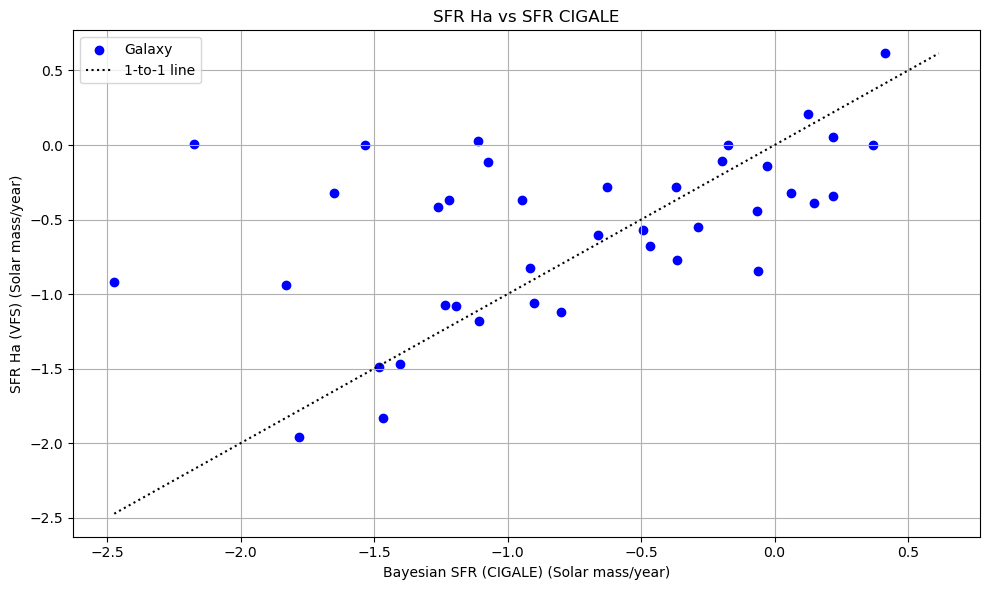

In [24]:
# Set up directories
os.environ['HOME'] = 'C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir + '/cigalestuff/cigale/out/'
fits1 = tabledir + 'results.fits'
fits2 = tabledir + 'vf_v2_halpha.fits'

# Function to load FITS data into a Pandas DataFrame
def fits_to_dataframe(fits_file, columns=None):
    with fits.open(fits_file) as hdul:
        data = hdul[1].data
        df = pd.DataFrame(data.tolist(), columns=data.names)
        if columns:
            df = df[columns]
        return df

# Load both FITS tables as DataFrames
df1 = fits_to_dataframe(fits1, columns=['id', 'bayes.sfh.sfr', 'bayes.sfh.sfr_err'])
df2 = fits_to_dataframe(fits2, columns=['VFID', 'GAL_LOG_SFR_HA', 'GAL_LOG_SFR_HA_ERR', 'GAL_LOG_SFR_HA_FLAG'])

# Ensure data types match for the merge (e.g., converting IDs to strings if needed)
df1['id'] = df1['id'].astype(str)
df2['VFID'] = df2['VFID'].astype(str)

# Cross-match the tables using the first table's 'id' and the second table's 'VFID'
merged_df = pd.merge(df1, df2, left_on='id', right_on='VFID')

# Filter out rows where GAL_LOG_SFR_HA_FLAG is False
filtered_df = merged_df[merged_df['GAL_LOG_SFR_HA_FLAG'] == True]

# Convert bayes.sfh.sfr to log space (handling non-positive values)
filtered_df = filtered_df[filtered_df['bayes.sfh.sfr'] > 0]  # Remove non-positive values to avoid log errors
filtered_df['log_bayes_sfh_sfr'] = np.log10(filtered_df['bayes.sfh.sfr'])

# Check if there is valid data after filtering
if not filtered_df.empty:
    # Calculate the best-fit line using linear regression
    slope, intercept, _, _, _ = linregress(
        filtered_df['log_bayes_sfh_sfr'], filtered_df['GAL_LOG_SFR_HA']
    )

    # Scatter plot for log_bayes_sfh_sfr vs GAL_LOG_SFR_HA
    plt.figure(figsize=(10, 6))
    plt.scatter(
        filtered_df['log_bayes_sfh_sfr'], 
        filtered_df['GAL_LOG_SFR_HA'], 
        color='blue', 
        label='Galaxy'
    )
    

    # Plot the 1-to-1 line
    min_val = min(filtered_df['log_bayes_sfh_sfr'].min(), filtered_df['GAL_LOG_SFR_HA'].min())
    max_val = max(filtered_df['log_bayes_sfh_sfr'].max(), filtered_df['GAL_LOG_SFR_HA'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle=':', linewidth=1.5, label='1-to-1 line')

    # Set title and labels
    plt.title('SFR Ha vs SFR CIGALE')
    plt.xlabel('Bayesian SFR (CIGALE) (Solar mass/year)')
    plt.ylabel('SFR Ha (VFS) (Solar mass/year)')
    plt.grid(True)
    plt.legend()

    # Save and show the plot
    plt.tight_layout()
    plt.savefig('sfr_bayes_comparison_plot.png', dpi=300)
    plt.show()

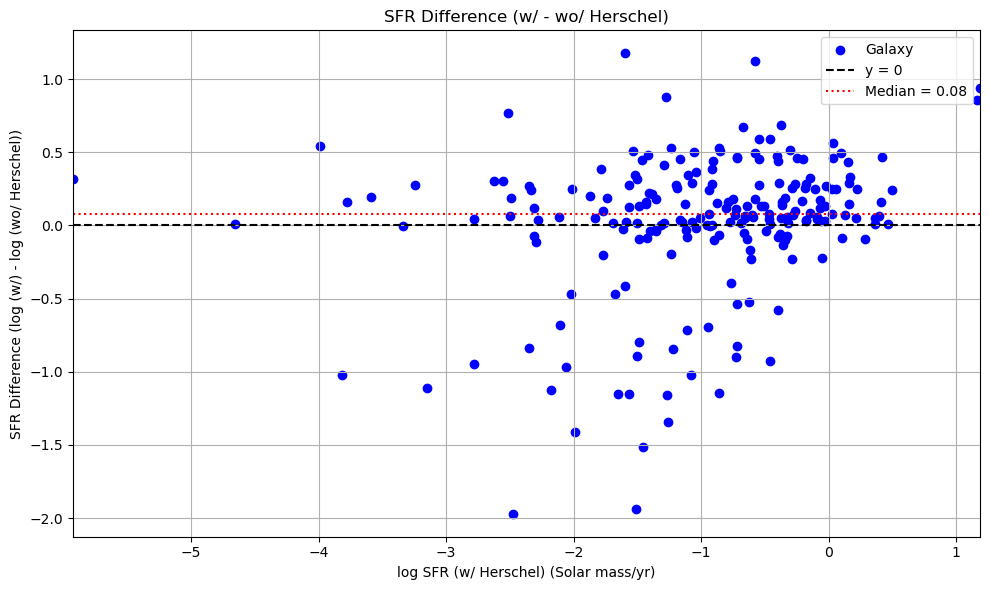

In [32]:
# Set up directories
os.environ['HOME'] = 'C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir + '/cigalestuff/cigale/out/'
fits1 = tabledir + 'results.fits'
fits2 = tabledir + 'resultsnoHerschel.fits'

# Function to load FITS data into a Pandas DataFrame
def fits_to_dataframe(fits_file, columns=None):
    with fits.open(fits_file) as hdul:
        data = hdul[1].data
        df = pd.DataFrame(data.tolist(), columns=data.names)
        if columns:
            df = df[columns]
        return df

# Load both FITS tables as DataFrames
columns_to_extract = ['id', 'bayes.sfh.sfr']
df1 = fits_to_dataframe(fits1, columns=columns_to_extract)
df2 = fits_to_dataframe(fits2, columns=columns_to_extract)

# Ensure data types match for the merge (e.g., converting IDs to strings if needed)
df1['id'] = df1['id'].astype(str)
df2['id'] = df2['id'].astype(str)

# Merge the tables by the 'id' column
merged_df = pd.merge(df1, df2, on='id', suffixes=('_fits1', '_fits2'))

# Filter out rows where SFR values are non-positive to avoid log errors
merged_df = merged_df[(merged_df['bayes.sfh.sfr_fits1'] > 0) & (merged_df['bayes.sfh.sfr_fits2'] > 0)]

# Convert SFR values to log10 space
merged_df['log_bayes_sfh_sfr_fits1'] = np.log10(merged_df['bayes.sfh.sfr_fits1'])
merged_df['log_bayes_sfh_sfr_diff'] = np.log10(merged_df['bayes.sfh.sfr_fits1']) - np.log10(merged_df['bayes.sfh.sfr_fits2'])

# Calculate the median of the plotted SFR difference values
median_diff = merged_df['log_bayes_sfh_sfr_diff'].median()

# Define plot limits for consistent scaling and plotting
x_min = merged_df['log_bayes_sfh_sfr_fits1'].min()
x_max = merged_df['log_bayes_sfh_sfr_fits1'].max()

# Plot SFR with Herschel vs. the difference in SFRs
plt.figure(figsize=(10, 6))
plt.scatter(
    merged_df['log_bayes_sfh_sfr_fits1'], 
    merged_df['log_bayes_sfh_sfr_diff'], 
    color='blue', 
    label='Galaxy'
)
plt.axhline(0, color='black', linestyle='--', label='y = 0')  # y=0 line for reference
plt.axhline(median_diff, color='red', linestyle=':', label=f'Median = {median_diff:.2f}')  # median line

# Set title and labels
plt.title('SFR Difference (w/ - wo/ Herschel)')
plt.xlabel('log SFR (w/ Herschel) (Solar mass/yr)')
plt.ylabel('SFR Difference (log (w/) - log (wo/ Herschel))')
plt.xlim(x_min, x_max)
plt.grid(True)
plt.legend()

# Save and show the plot
plt.tight_layout()
plt.savefig('sfr_bayes_difference_plot.png', dpi=300)
plt.show()

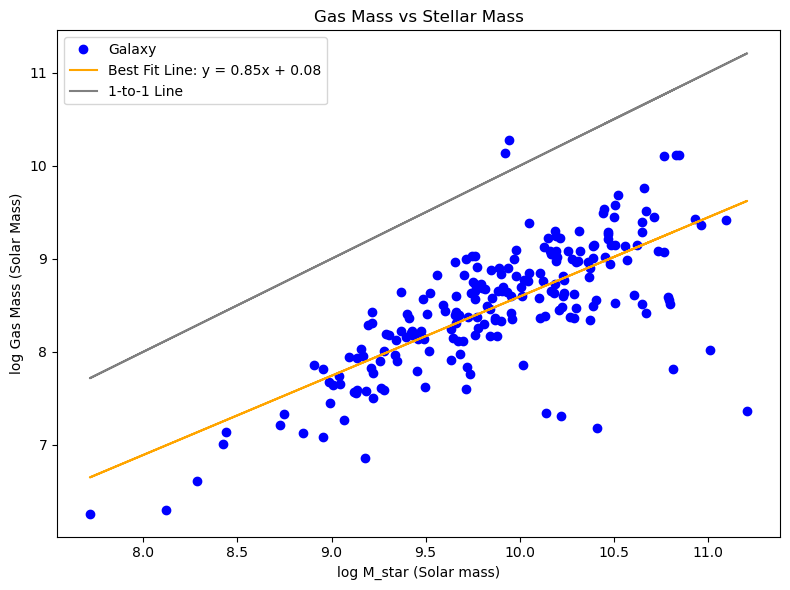

In [22]:
# Set up directories
os.environ['HOME'] = 'C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir + '/cigalestuff/cigale/out/'
fits_file = tabledir + 'results.fits'

# Load CSV files
first_csv_file = 'reference_gas_mass.csv'  # Replace with the actual path
df1 = pd.read_csv(first_csv_file)
second_csv_file = 'testoutput.csv'  # Replace with the actual path
df2 = pd.read_csv(second_csv_file)

# Merge the DataFrames on VFID and id
merged_df = pd.merge(df1, df2, left_on='VFID', right_on='id')

# Extract the Bayesian gas mass column
bayes_gas_mass = merged_df['log(bayes.gas.mass)']

# Load the FITS file and extract the best stellar mass data
with fits.open(fits_file) as hdul:
    fits_data = hdul[1].data
    fits_df = pd.DataFrame(fits_data.tolist(), columns=fits_data.names)
    fits_df['id'] = fits_df['id'].astype(str)  # Ensure 'id' is of type string

# Merge with the best stellar mass column from the FITS file
merged_df = pd.merge(merged_df, fits_df[['id', 'bayes.stellar.m_star']], left_on='VFID', right_on='id', suffixes=('', '_fits'))

# Convert best stellar mass to log space and filter out non-positive values
merged_df = merged_df[merged_df['bayes.stellar.m_star'] > 0]  # Filter out non-positive stellar mass values
merged_df['log_bayes_stellar_m_star'] = np.log10(merged_df['bayes.stellar.m_star'])

# Filter out non-zero and non-NaN values for bayesian gas mass
valid_bayes_mask = (~np.isnan(merged_df['log_bayes_stellar_m_star'])) & (~np.isnan(bayes_gas_mass))

# Calculate the best fit line for bayes gas mass vs best stellar mass
slope_bayes, intercept_bayes, _, _, _ = linregress(
    merged_df['log_bayes_stellar_m_star'][valid_bayes_mask], 
    bayes_gas_mass[valid_bayes_mask]
)

# Plotting
plt.figure(figsize=(8, 6))

# Plot: log_best_stellar_m_star vs bayes_gas_mass
plt.plot(merged_df['log_bayes_stellar_m_star'], bayes_gas_mass, 'o', color='blue', label='Galaxy')
plt.plot(merged_df['log_bayes_stellar_m_star'], slope_bayes * merged_df['log_bayes_stellar_m_star'] + intercept_bayes, color='orange', linestyle='-', label=f'Best Fit Line: y = {slope_bayes:.2f}x + {intercept_bayes:.2f}')
plt.plot(merged_df['log_bayes_stellar_m_star'], merged_df['log_bayes_stellar_m_star'], color='gray', linestyle='-', label='1-to-1 Line')

plt.xlabel('log M_star (Solar mass)')
plt.ylabel('log Gas Mass (Solar Mass)')
plt.title('Gas Mass vs Stellar Mass')
plt.legend()

# Adjust layout, save, and display
plt.tight_layout()
plt.savefig('bayes_gas_vs_log_best_stellar_mass.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'slope_bayes' is not defined

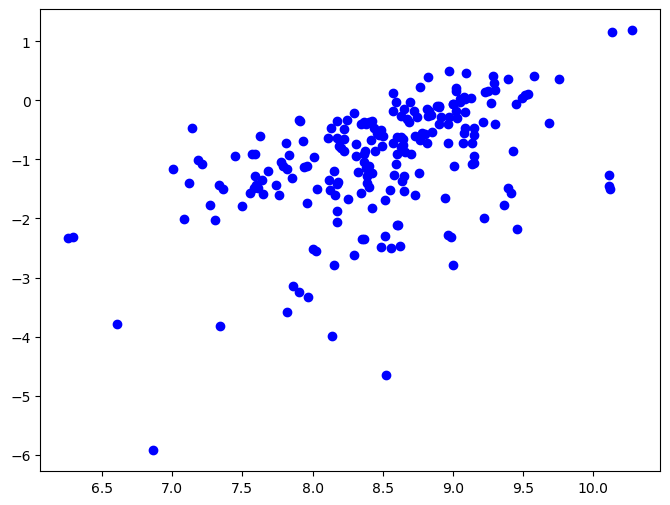

In [3]:
# Set up directories
os.environ['HOME'] = 'C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir + '/cigalestuff/cigale/out/'
fits_file = tabledir + 'results.fits'

# Load CSV files
first_csv_file = 'reference_gas_mass.csv'  # Replace with the actual path
df1 = pd.read_csv(first_csv_file)
second_csv_file = 'testoutput.csv'  # Replace with the actual path
df2 = pd.read_csv(second_csv_file)

# Merge the DataFrames on VFID and id
merged_df = pd.merge(df1, df2, left_on='VFID', right_on='id')

# Extract the Bayesian gas mass column
bayes_gas_mass = merged_df['log(bayes.gas.mass)']

# Load the FITS file and extract the Bayesian SFR data
with fits.open(fits_file) as hdul:
    fits_data = hdul[1].data
    fits_df = pd.DataFrame(fits_data.tolist(), columns=fits_data.names)
    fits_df['id'] = fits_df['id'].astype(str)  # Ensure 'id' is of type string

# Merge with the Bayesian SFR column from the FITS file
merged_df = pd.merge(merged_df, fits_df[['id', 'bayes.sfh.sfr']], left_on='VFID', right_on='id', suffixes=('', '_fits'))

# Convert Bayesian SFR to log space and filter out non-positive values
merged_df = merged_df[merged_df['bayes.sfh.sfr'] > 0]  # Filter out non-positive SFR values
merged_df['log_bayes_sfh_sfr'] = np.log10(merged_df['bayes.sfh.sfr'])

# Filter out non-zero and non-NaN values for bayesian gas mass
valid_bayes_mask = (~np.isnan(merged_df['log_bayes_sfh_sfr'])) & (~np.isnan(bayes_gas_mass))

# Calculate the best fit line for bayes gas mass vs log_bayes_sfh_sfr with axes reversed
#slope_bayes, intercept_bayes, _, _, _ = linregress(
#    bayes_gas_mass[valid_bayes_mask], 
#    merged_df['log_bayes_sfh_sfr'][valid_bayes_mask]
#)

# Plotting
plt.figure(figsize=(8, 6))

# Plot: bayes_gas_mass vs log_bayes_sfh_sfr (axes reversed)
plt.plot(bayes_gas_mass, merged_df['log_bayes_sfh_sfr'], 'o', color='blue', label='Galaxy')
plt.plot(bayes_gas_mass, slope_bayes * bayes_gas_mass + intercept_bayes, color='orange', linestyle='-', label=f'Best Fit Line: y = {slope_bayes:.2f}x + {intercept_bayes:.2f}')

# Update labels and title to reflect reversed axes
plt.xlabel('Log Gas Mass (Solar Mass)')
plt.ylabel('log(SFR (Solar Mass/yr))')
plt.title('SFR vs Gas Mass')
plt.legend()

# Adjust layout, save, and display
plt.tight_layout()
plt.savefig('gas_mass_vs_sfr.png', dpi=300, bbox_inches='tight')
plt.show()


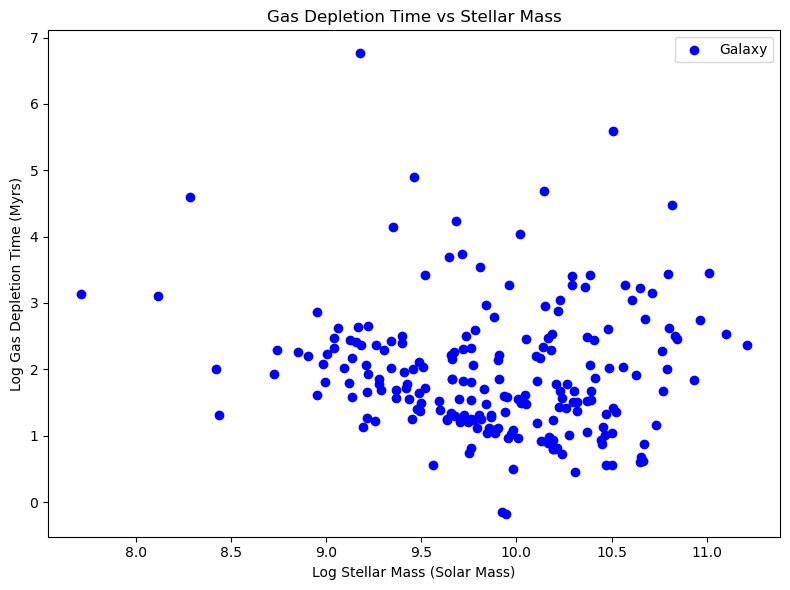

In [2]:
# Set up directories
os.environ['HOME'] = 'C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir + '/cigalestuff/cigale/out/'
fits_file = tabledir + 'results.fits'

# Load CSV files
first_csv_file = 'reference_gas_mass.csv'  # Replace with the actual path
df1 = pd.read_csv(first_csv_file)
second_csv_file = 'testoutput.csv'  # Replace with the actual path
df2 = pd.read_csv(second_csv_file)

# Merge the DataFrames on VFID and id
merged_df = pd.merge(df1, df2, left_on='VFID', right_on='id')

# Extract the Bayesian gas mass column
bayes_gas_mass = merged_df['log(bayes.gas.mass)']

# Load the FITS file and extract the Bayesian SFR and stellar mass data
with fits.open(fits_file) as hdul:
    fits_data = hdul[1].data
    fits_df = pd.DataFrame(fits_data.tolist(), columns=fits_data.names)
    fits_df['id'] = fits_df['id'].astype(str)  # Ensure 'id' is of type string

# Merge with the Bayesian SFR and stellar mass columns from the FITS file
merged_df = pd.merge(
    merged_df, 
    fits_df[['id', 'bayes.sfh.sfr', 'bayes.stellar.m_star']], 
    left_on='VFID', 
    right_on='id', 
    suffixes=('', '_fits')
)

# Convert Bayesian SFR to log space, filter out non-positive values
merged_df = merged_df[merged_df['bayes.sfh.sfr'] > 0]  # Filter out non-positive SFR values
merged_df['log_bayes_sfh_sfr'] = np.log10(merged_df['bayes.sfh.sfr'])

# Calculate t_dep as M_gas / SFR in linear space, then convert to log space
merged_df['tdep'] = bayes_gas_mass / merged_df['bayes.sfh.sfr']
merged_df['log_tdep'] = np.log10(merged_df['tdep'])  # Convert to log space

# Convert M_star to log space for plotting
merged_df['log_bayes_stellar_m_star'] = np.log10(merged_df['bayes.stellar.m_star'])

# Plotting log_tdep vs M_star
plt.figure(figsize=(8, 6))
plt.scatter(
    merged_df['log_bayes_stellar_m_star'], 
    merged_df['log_tdep'], 
    color='blue', 
    label='Galaxy'
)

plt.xlabel('Log Stellar Mass (Solar Mass)')
plt.ylabel('Log Gas Depletion Time (Myrs)')
plt.title('Gas Depletion Time vs Stellar Mass')
plt.legend()

# Adjust layout, save, and display
plt.tight_layout()
plt.savefig('log_tdep_vs_mstar.png', dpi=300, bbox_inches='tight')
plt.show()

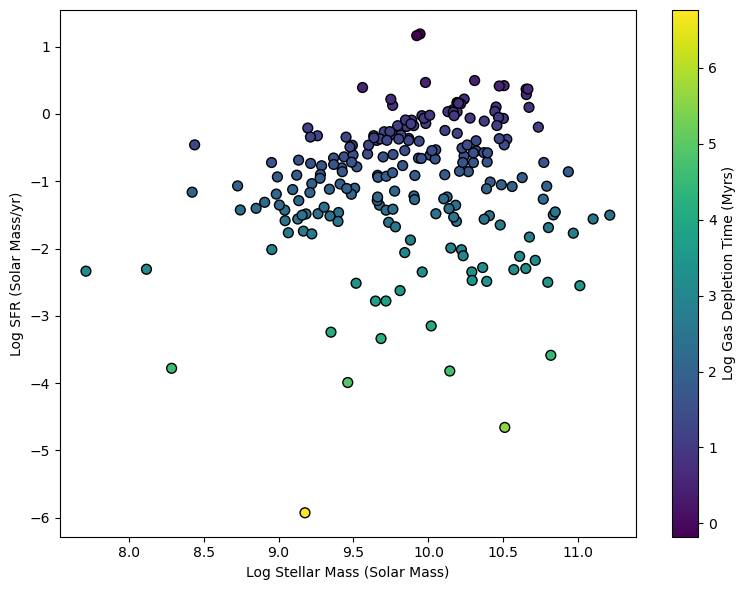

In [4]:
# Set up directories
os.environ['HOME'] = 'C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir + '/cigalestuff/cigale/out/'
fits_file = tabledir + 'results.fits'

# Load CSV files
first_csv_file = 'reference_gas_mass.csv'  # Replace with the actual path
df1 = pd.read_csv(first_csv_file)
second_csv_file = 'testoutput.csv'  # Replace with the actual path
df2 = pd.read_csv(second_csv_file)

# Merge the DataFrames on VFID and id
merged_df = pd.merge(df1, df2, left_on='VFID', right_on='id')

# Extract the Bayesian gas mass column
bayes_gas_mass = merged_df['log(bayes.gas.mass)']

# Load the FITS file and extract the Bayesian SFR and stellar mass data
with fits.open(fits_file) as hdul:
    fits_data = hdul[1].data
    fits_df = pd.DataFrame(fits_data.tolist(), columns=fits_data.names)
    fits_df['id'] = fits_df['id'].astype(str)  # Ensure 'id' is of type string

# Merge with the Bayesian SFR and stellar mass columns from the FITS file
merged_df = pd.merge(
    merged_df, 
    fits_df[['id', 'bayes.sfh.sfr', 'bayes.stellar.m_star']], 
    left_on='VFID', 
    right_on='id', 
    suffixes=('', '_fits')
)

# Filter out non-positive SFR values
merged_df = merged_df[merged_df['bayes.sfh.sfr'] > 0]  # Filter out non-positive SFR values
merged_df['log_bayes_sfh_sfr'] = np.log10(merged_df['bayes.sfh.sfr'])

# Calculate t_dep as M_gas / SFR in linear space, then convert to log space
merged_df['tdep'] = bayes_gas_mass / merged_df['bayes.sfh.sfr']
merged_df['log_tdep'] = np.log10(merged_df['tdep'])  # Convert to log space

# Convert M_star and SFR to log space for plotting
merged_df['log_bayes_stellar_m_star'] = np.log10(merged_df['bayes.stellar.m_star'])
merged_df['log_bayes_sfh_sfr'] = np.log10(merged_df['bayes.sfh.sfr'])

# Plot M_star vs SFR, color-coded by log(t_dep)
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    merged_df['log_bayes_stellar_m_star'], 
    merged_df['log_bayes_sfh_sfr'], 
    c=merged_df['log_tdep'], 
    cmap='viridis', 
    edgecolor='k', 
    s=50
)
cbar = plt.colorbar(sc)
cbar.set_label('Log Gas Depletion Time (Myrs)')

# Label axes and title
plt.xlabel('Log Stellar Mass (Solar Mass)')
plt.ylabel('Log SFR (Solar Mass/yr)')
#plt.title('SFR vs Stellar Mass, Colored by Gas Depletion Time')

# Save and display the plot
plt.tight_layout()
plt.savefig('mstar_vs_sfr_colored_by_tdep.png', dpi=300, bbox_inches='tight')
plt.show()


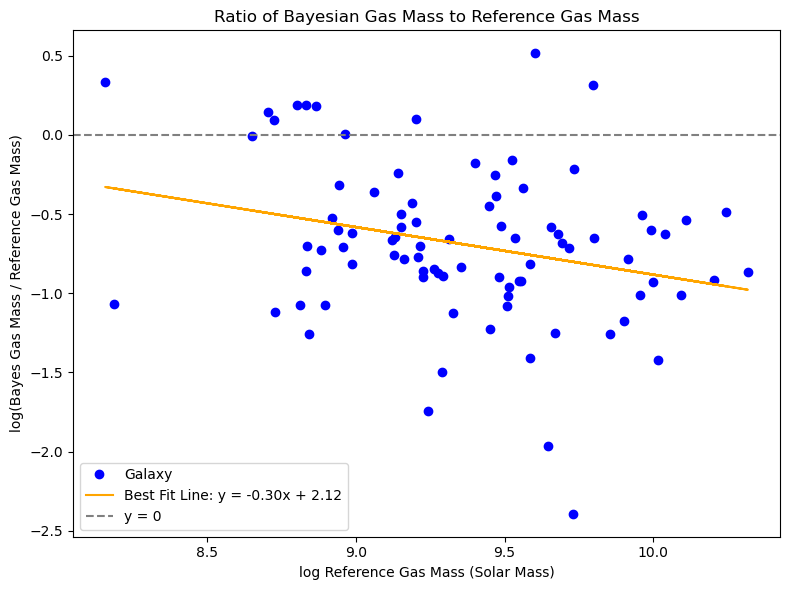

In [7]:
first_csv_file = 'reference_gas_mass.csv'  # Replace with the actual path
df1 = pd.read_csv(first_csv_file)
second_csv_file = 'testoutput.csv'  # Replace with the actual path
df2 = pd.read_csv(second_csv_file)

# Merge the DataFrames on VFID and id
merged_df = pd.merge(df1, df2, left_on='VFID', right_on='id')

# Extract necessary columns for calculations
Mgas = merged_df['Mgas']  # Reference gas mass
bayes_gas_mass = merged_df['log(bayes.gas.mass)']  # Bayesian gas mass in log space

# Filter out invalid entries
valid_mask = (Mgas > 0) & (~np.isnan(Mgas)) & (~np.isnan(bayes_gas_mass))

# Calculate log(Bayes Gas Mass / Reference Gas Mass)
log_reference_gas_mass = (Mgas[valid_mask])
log_mass_ratio = bayes_gas_mass[valid_mask] - log_reference_gas_mass

# Perform linear regression
slope, intercept, _, _, _ = linregress(log_reference_gas_mass, log_mass_ratio)

# Plotting
plt.figure(figsize=(8, 6))

# Plot log(Bayes Gas Mass / Reference Gas Mass) vs log(Reference Gas Mass)
plt.plot(log_reference_gas_mass, log_mass_ratio, 'o', color='blue', label='Galaxy')
plt.plot(
    log_reference_gas_mass, 
    slope * log_reference_gas_mass + intercept, 
    color='orange', 
    linestyle='-', 
    label=f'Best Fit Line: y = {slope:.2f}x + {intercept:.2f}'
)
plt.axhline(0, color='gray', linestyle='--', label='y = 0')

# Label axes and title
plt.xlabel('log Reference Gas Mass (Solar Mass)')
plt.ylabel('log(Bayes Gas Mass / Reference Gas Mass)')
plt.title('Ratio of Bayesian Gas Mass to Reference Gas Mass')
plt.legend()

# Adjust layout, save, and display
plt.tight_layout()
plt.savefig('bayes_mass_ratio_vs_reference_mass.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
#merging the 2 tables
# Load the CSV files
csv1 = 'table3.csv'  # Replace with actual file name
csv2 = 'table4.csv'  # Replace with actual file name
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)

# Rename columns to have a common name for merging
if 'CO_trans' in df1.columns:
    df1.rename(columns={'CO_trans': 'CO'}, inplace=True)
if 'COtrans' in df2.columns:
    df2.rename(columns={'COtrans': 'CO'}, inplace=True)

# Add a column to indicate source file
df1['Source'] = 'table3'
df2['Source'] = 'table4'

# Select only the relevant columns
df1_selected = df1[['Galaxy', 'fap', 'CO', 'Source', 'log(MH2)']]
df2_selected = df2[['Galaxy', 'fap', 'CO', 'Source', 'log(MH2)']]

# Concatenate the two datasets
merged_df = pd.concat([df1_selected, df2_selected])

# Save the full merged file
merged_csv = 'merged_f_ap_table.csv'
merged_df.to_csv(merged_csv, index=False)

# Filter only rows where CO == "1→0"
filtered_df = merged_df[merged_df['CO'] == "1-->0"]

# Save the filtered file
filtered_csv = 'filtered_f_ap.csv'
filtered_df.to_csv(filtered_csv, index=False)

print(f"Merged data saved to {merged_csv}")
print(f"Filtered data (CO = '1→0') saved to {filtered_csv}")

Merged data saved to merged_f_ap_table.csv
Filtered data (CO = '1→0') saved to filtered_f_ap.csv


In [29]:
# Input file paths
csv_file1 = "filtered_f_ap.csv"  # File with Galaxy, CO, and log(MH2)
csv_file2 = "Photometrytesting2.csv"  # File with VF_IDs

# Load CSV files
csv_df1 = pd.read_csv(csv_file1)
csv_df2 = pd.read_csv(csv_file2)

# Ensure 'Galaxy' and 'GALAXY' columns are in a consistent format
csv_df1['Galaxy'] = csv_df1['Galaxy'].astype(str).str.strip()
csv_df2['GALAXY'] = csv_df2['GALAXY'].astype(str).str.strip()

# Format VF_ID properly
csv_df2['VFID'] = csv_df2['VF_ID'].apply(lambda x: f"VFID{int(x):04d}" if pd.notna(x) else None)

# Create a list to store matched rows
matched_rows = []

# Loop through each row in csv_df2 to find matching galaxies
for index, row in csv_df2.iterrows():
    galaxy = row['GALAXY']
    vfid = row['VFID']
    
    # Find rows in csv_df1 matching the galaxy name
    galaxy_matches = csv_df1[csv_df1['Galaxy'] == galaxy]
    
    if not galaxy_matches.empty:
        # Prioritize rows where CO == "1-->0"
        co_rows = galaxy_matches[galaxy_matches['CO'] == "1-->0"]
        
        # Select the appropriate row (prefer "1-->0" match, otherwise take any match)
        selected_row = co_rows.iloc[0] if not co_rows.empty else galaxy_matches.iloc[0]
        
        # Extract log(MH2) from csv_df1
        log_mh2 = selected_row['log(MH2)'] if 'log(MH2)' in selected_row else None
        
        # Append selected row as a dictionary (to ensure correct merging)
        selected_dict = selected_row.to_dict()
        selected_dict['VFID'] = vfid  # Add VFID column
        selected_dict['log(MH2)'] = log_mh2  # Ensure log(MH2) is included
        matched_rows.append(selected_dict)

# Convert list of matched rows into a DataFrame
filtered_csv_df = pd.DataFrame(matched_rows)

# Save the filtered data
output_csv_file = "filtered_asu.csv"
filtered_csv_df.to_csv(output_csv_file, index=False)

print(f"Filtered data saved as {output_csv_file}.")

Filtered data saved as filtered_asu.csv.


VFIDs with log(Bayes Gas Mass / Reference Gas Mass) below -2:
VFID2068


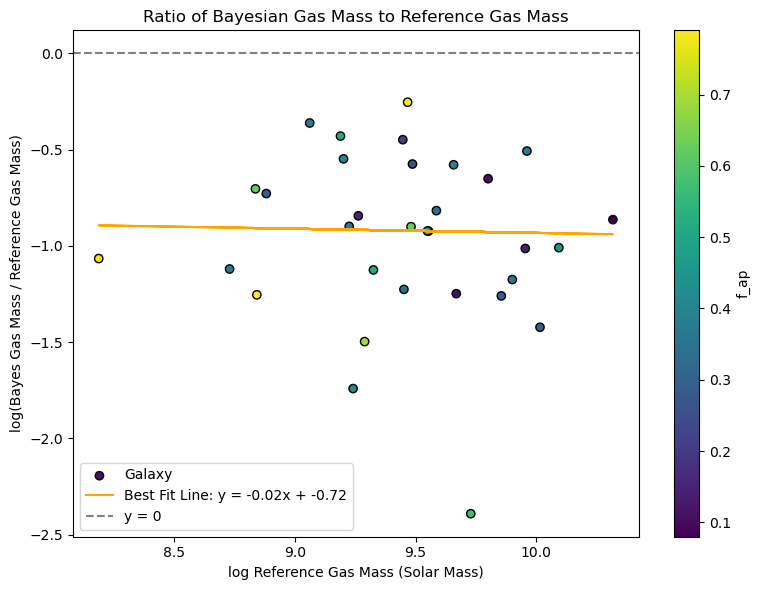

In [3]:
# Input CSV files
first_csv_file = 'reference_gas_mass.csv'  # Path to the first CSV file
second_csv_file = 'testoutput.csv'  # Path to the second CSV file
third_csv_file = 'filtered_asu.csv'  # Path to the third CSV file (filtered_asu)

# Load the CSV files
df1 = pd.read_csv(first_csv_file)
df2 = pd.read_csv(second_csv_file)
filtered_asu_df = pd.read_csv(third_csv_file)

# Merge the DataFrames on VFID and id
merged_df = pd.merge(df1, df2, left_on='VFID', right_on='id')

# Extract necessary columns for calculations
Mgas = merged_df['Mgas']  # Reference gas mass
bayes_gas_mass = merged_df['log(bayes.gas.mass)']  # Bayesian gas mass in log space

# Filter out invalid entries
valid_mask = (Mgas > 0) & (~np.isnan(Mgas)) & (~np.isnan(bayes_gas_mass))

# Calculate log(Bayes Gas Mass / Reference Gas Mass)
log_reference_gas_mass = Mgas[valid_mask]
log_mass_ratio = bayes_gas_mass[valid_mask] - log_reference_gas_mass

# Merge with the third CSV file to filter based on VFID
filtered_vfids = filtered_asu_df['VFID']  # Assuming 'VFID' column exists in filtered_asu.csv
merged_filtered_df = merged_df[merged_df['VFID'].isin(filtered_vfids)]

# Apply the mask to the filtered data
filtered_log_reference_gas_mass = log_reference_gas_mass[merged_df['VFID'].isin(filtered_vfids)]
filtered_log_mass_ratio = log_mass_ratio[merged_df['VFID'].isin(filtered_vfids)]
filtered_fap_values = filtered_asu_df.loc[filtered_asu_df['VFID'].isin(filtered_vfids), 'fap']  # Assuming 'fap' column exists

# Identify points where log_mass_ratio < -2 and print their VFIDs
outlier_mask = filtered_log_mass_ratio < -2
outlier_vfids = merged_filtered_df.loc[outlier_mask, 'VFID']

if not outlier_vfids.empty:
    print("VFIDs with log(Bayes Gas Mass / Reference Gas Mass) below -2:")
    print(outlier_vfids.to_string(index=False))
else:
    print("No VFIDs found with log_mass_ratio below -2.")

# Perform linear regression
slope, intercept, _, _, _ = linregress(filtered_log_reference_gas_mass, filtered_log_mass_ratio)

# Plotting
plt.figure(figsize=(8, 6))

# Plot log(Bayes Gas Mass / Reference Gas Mass) vs log(Reference Gas Mass) with color-coding by fap
scatter = plt.scatter(filtered_log_reference_gas_mass, filtered_log_mass_ratio, c=filtered_fap_values, cmap='viridis', label='Galaxy', edgecolors='k')

# Plot the best fit line
plt.plot(
    filtered_log_reference_gas_mass, 
    slope * filtered_log_reference_gas_mass + intercept, 
    color='orange', 
    linestyle='-', 
    label=f'Best Fit Line: y = {slope:.2f}x + {intercept:.2f}'
)

# Add a color bar for the fap values
plt.colorbar(scatter, label='f_ap')

# Add a horizontal line at y=0 for reference
plt.axhline(0, color='gray', linestyle='--', label='y = 0')

# Label axes and title
plt.xlabel('log Reference Gas Mass (Solar Mass)')
plt.ylabel('log(Bayes Gas Mass / Reference Gas Mass)')
plt.title('Ratio of Bayesian Gas Mass to Reference Gas Mass')
plt.legend()

# Adjust layout, save, and display
plt.tight_layout()
plt.savefig('bayes_mass_ratio_vs_reference_mass_filtered.png', dpi=300, bbox_inches='tight')
plt.show()


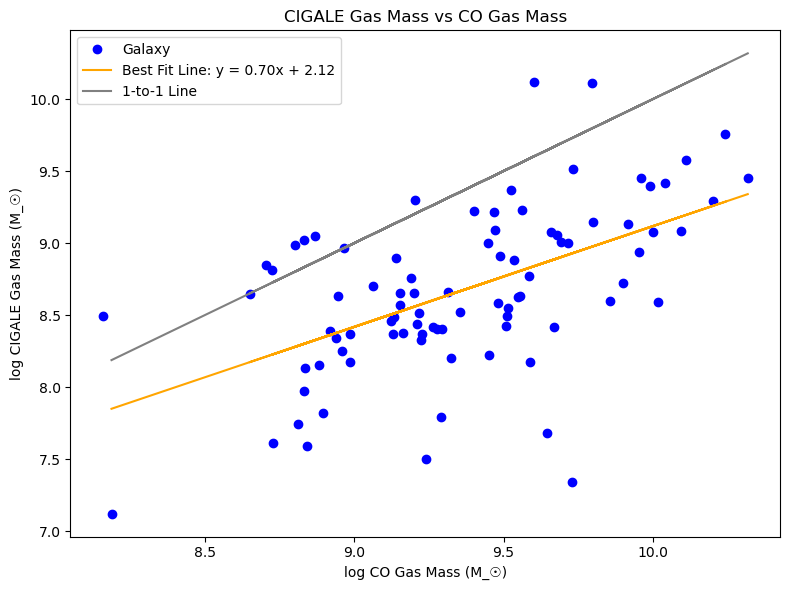

In [5]:
# Load CSV files
first_csv_file = 'reference_gas_mass.csv'  # Replace with the actual path
df1 = pd.read_csv(first_csv_file)
second_csv_file = 'testoutput.csv'  # Replace with the actual path
df2 = pd.read_csv(second_csv_file)

# Merge the DataFrames on VFID and id
merged_df = pd.merge(df1, df2, left_on='VFID', right_on='id')

# Extract necessary columns for plotting
Mgas = merged_df['Mgas']  # Reference gas mass
bayes_gas_mass = merged_df['log(bayes.gas.mass)']  # Bayesian gas mass in log space

# Filter out non-zero and non-NaN values for best fit calculations
valid_mask = (Mgas > 0) & (bayes_gas_mass > 0) & (~np.isnan(Mgas)) & (~np.isnan(bayes_gas_mass))

# Perform linear regression for the Bayesian gas mass
slope_bayes, intercept_bayes, _, _, _ = linregress(Mgas[valid_mask], bayes_gas_mass[valid_mask])

# Plotting
plt.figure(figsize=(8, 6))

# Scatter plot of Mgas vs bayes_gas_mass
plt.plot(Mgas, bayes_gas_mass, 'o', color='blue', label='Galaxy')

# Plot best fit line
plt.plot(Mgas, slope_bayes * Mgas + intercept_bayes, color='orange', linestyle='-', label=f'Best Fit Line: y = {slope_bayes:.2f}x + {intercept_bayes:.2f}')

# Plot 1-to-1 line
plt.plot(Mgas, Mgas, color='gray', linestyle='-', label='1-to-1 Line')

# Label axes and add title
plt.xlabel('log CO Gas Mass (M_☉)')
plt.ylabel('log CIGALE Gas Mass (M_☉)')
plt.title('CIGALE Gas Mass vs CO Gas Mass')
plt.legend()

# Adjust layout, save, and display
plt.tight_layout()
plt.savefig('bayes_gas_mass_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# Set up directories
os.environ['HOME'] = 'C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir + '/cigalestuff/cigale/out/'
csv_file = 'testoutput.csv'  # CSV containing bayes.gas.mass
fits_file = tabledir + 'vf_v2_halpha.fits'
mgas_csv_file = 'reference_gas_mass.csv'  # CSV containing 'Mgas'

# Function to load FITS data into a Pandas DataFrame
def fits_to_dataframe(fits_file, columns=None):
    with fits.open(fits_file) as hdul:
        data = hdul[1].data
        df = pd.DataFrame(data.tolist(), columns=data.names)
        if columns:
            df = df[columns]
        return df

# Load CSV file as DataFrame
df1 = pd.read_csv(csv_file, usecols=['id', 'log(bayes.gas.mass)', 'bayes.sfh.sfr'])

# Convert log(bayes.gas.mass) to normal space
df1['bayes.gas.mass'] = 10 ** df1['log(bayes.gas.mass)']

# Load FITS table as DataFrame
df2 = fits_to_dataframe(fits_file, columns=['VFID', 'GAL_LOG_SFR_HA', 'GAL_LOG_SFR_HA_ERR', 'GAL_LOG_SFR_HA_FLAG'])

# Load additional CSV file with Mgas
df3 = pd.read_csv(mgas_csv_file, usecols=['VFID', 'Mgas'])

# Ensure data types match for merging
df1['id'] = df1['id'].astype(str)
df2['VFID'] = df2['VFID'].astype(str)
df3['VFID'] = df3['VFID'].astype(str)

# Merge df1 and df2 using 'id' and 'VFID'
merged_df = pd.merge(df1, df2, left_on='id', right_on='VFID')

# Merge with df3 to include 'Mgas'
merged_df = pd.merge(merged_df, df3, on='VFID', how='left')

# Filter out rows where GAL_LOG_SFR_HA_FLAG is False
filtered_df = merged_df[merged_df['GAL_LOG_SFR_HA_FLAG'] == True]

# Convert SFR values from log space to normal space
filtered_df['SFR1'] = 10 ** filtered_df['GAL_LOG_SFR_HA']
filtered_df['SFR2'] = 10 ** filtered_df['bayes.sfh.sfr']

# Ensure valid data for calculation: bayes.gas.mass > 0 and SFR > 0
filtered_df = filtered_df[(filtered_df['Mgas'] > 0) & (filtered_df['SFR1'] > 0)]

# Calculate depletion time using SFR1
filtered_df['t_dep1(CO)'] = 10**(filtered_df['Mgas']) / filtered_df['SFR1']

# Ensure valid data for calculation: bayes.gas.mass > 0 and SFR2 > 0
filtered_df = filtered_df[(filtered_df['Mgas'] > 0) & (filtered_df['SFR2'] > 0)]

# Calculate depletion time using SFR2
filtered_df['t_dep2(CIGALE)'] = 10**filtered_df['Mgas'] / filtered_df['SFR2']

# Save to CSV with the selected parameters including 'Mgas'
output_csv = 'depletion_time_table.csv'
filtered_df[['id', 'bayes.gas.mass', 'GAL_LOG_SFR_HA', 't_dep1(CO)', 'bayes.sfh.sfr', 't_dep2(CIGALE)', 'Mgas']].to_csv(output_csv, index=False)

print(f"Depletion time table saved to {output_csv}")


Depletion time table saved to depletion_time_table.csv


C:\Users\USER\AppData\Local\Temp\ipykernel_11384\3706379304.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['SFR1'] = 10 ** filtered_df['GAL_LOG_SFR_HA']
C:\Users\USER\AppData\Local\Temp\ipykernel_11384\3706379304.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['SFR2'] = 10 ** filtered_df['bayes.sfh.sfr']


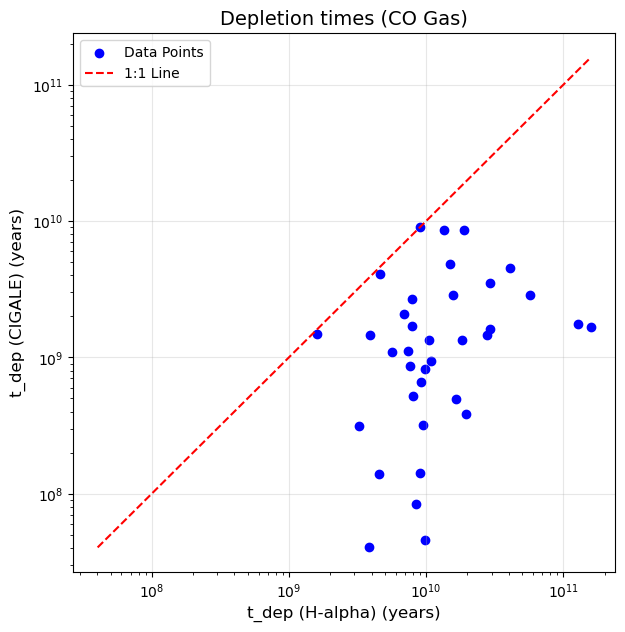

In [18]:
# Load the CSV file
csv_file = 'depletion_time_table.csv'
df = pd.read_csv(csv_file)

# Create the plot
plt.figure(figsize=(7, 7))
plt.scatter(df['t_dep1(CO)'], df['t_dep2(CIGALE)'], color='blue', alpha=1, label='Data Points')

# Add a 1-to-1 line (y = x)
min_val = min(df['t_dep1(CO)'].min(), df['t_dep2(CIGALE)'].min())  # Get min value for limits
max_val = max(df['t_dep1(CO)'].max(), df['t_dep2(CIGALE)'].max())  # Get max value for limits
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='1:1 Line')

# Labels and formatting
plt.xlabel('t_dep (H-alpha) (years)', fontsize=12)
plt.ylabel('t_dep (CIGALE) (years)', fontsize=12)
plt.title('Depletion times (CO Gas)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.xscale('log')  # Optional: Log scale if values vary widely
plt.yscale('log')  # Optional: Log scale

# Save and show the plot
plt.savefig('t_dep1_vs_t_dep2 (CO Gas).png', dpi=300)
plt.show()